# Propuesta de obtener parametros a partir del estudio del PSD:

En este archivo muestro solo el analisis del 'power spectrum density' (PSD). Inspirado en este link:
http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

En esta notebook, solo se sacan 3 señales, al principio (signal_1) en la mitad (signal_2) y al final (signal_3) todas del penultimo ciclo (o llamado en los articulos window), el ciclo 15.

Luego parto la señal, y se ve como varian los PSD de 36 segmentos de la señal. 

Al final la conclusión. 

train.cvs esta en la misma carpeta!

Inicialización de librerias:


In [1]:
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy as sp
from tsfresh.feature_extraction import feature_calculators
from scipy import signal

import os
print(os.listdir("./"))

# In most cases, is the number of sampled signal to define the time to failure of the signal
number_set0 = 4096 
#150_000 is the number of the sample of each test, so is make up of appproximatly 36 steps of signals
number_sample = 36 


['.ipynb_checkpoints', '01 Analisis -Copy1.ipynb', '01 Analisis .ipynb', '02 Analisis.ipynb', '04 Analisis.ipynb', '1 model.ipynb', '3 Analisis.ipynb', 'Analisis PSD.ipynb', 'Fase Final.ipynb', 'Prueba', 'sample_submission.csv', 'submission.csv', 'test', 'train.csv']


##The data is recorded in bins of 4096 samples. 
<p style="color:red;"> ## Question is len(df['acoustic'])/150000 should be 4096? </p>
<p style="color:red;">
<p style="color:red;">##SAMPLING FREQUENCY HAS ANY USE?</p>

Funciones para estudiar "Power spectrum density":
Reusadas de algún kernel en kagel:

In [2]:
#Definition of functions, to get the common features, and related to the spectrum shape.

sampling_frequency = 4e6

def get_spectrum(input_signal):
    """
    Get a pandas Series with the fourier power spectum for a given signal segment.
    """
    input_signal = np.asarray(input_signal.values, dtype='float64')
    
    # Remove the mean  
    input_signal -= input_signal.mean()  
    
    # Estimate power spectral density using a periodogram.
    frequencies , power_spectrum = signal.periodogram(input_signal, sampling_frequency, scaling='spectrum')    
    
    # Run a running windows average of 10-points to smooth the signal.
    power_spectrum = pd.Series(power_spectrum, index=frequencies).rolling(window=10).mean()        
    
    return pd.Series(power_spectrum)

def get_segment_spectrum(segment_df):
    """
    Get the fourier power spectrum of a given segment.
    
    Returns the quake_time, frequencies, and power_spectrum
    """
    
    quake_time =segment_df['time_to_failure'].values[-1]
    
    _power_spectrum = get_spectrum(segment_df['acoustic_data']).dropna() 
    
    # Keep only frequencies < 450khz (larger frequencies have a negligible contribution).
    _power_spectrum = _power_spectrum[_power_spectrum.index<450_000]
    
    # Keep one every 10 samples
    power_spectrum=_power_spectrum.values[::5]
    frequencies=_power_spectrum.index.values[::5]    
    
    return quake_time, frequencies, power_spectrum


Acá se define el reader, para leer por iteraciones el archivo, pues es muy grande. 
Y el tamaño por cada iteracion "number_load_data"

<p style="color:red;"> De donde salen los 16 ciclos (windows), son los 16 earthquakes?</p>


In [3]:
%%time
reader = pd.read_csv("./train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, iterator=True)
number_load_data = number_set0*20000
#There are 16 cycles in training data. then it is explored signals in the three following cycles
cycles_to_save = [1,7,15] 
#data = reader.get_chunk(number_load_data)
#Flag to finish the while in all the file
flag_done_load = 1 
#first cycle
cycle = 0
#to continue in next load of the file
last_cycle = 0

Wall time: 35.9 ms


En la siguinte se lee todo el archivo por partes, se salvan algunos fragmentos de los ciclos en 'cycles_to_save'. Aunque al final solo salva lo del ciclo 15. solo se sacan 3 señales, al principio (signal_1) en la mitad (signal_2) y al final (signal_3) todas del penultimo ciclo (o llamado en los articulos window), el ciclo 15.

In [4]:
#########################
#una lista {}
#############

data_left = pd.DataFrame({})

while flag_done_load:
    print('\n')
    #loading files of size number_load_data
    data = reader.get_chunk(number_load_data)
    #assert(len(data) == number_load_data)
    if len(data) != number_load_data:
        print('Seems, the loading data, it is done.')
        flag_done_load = 0
    
    
    # after first cycle, we concatenate the left data in before loop-wise with the upload data from file
   
    #print('Concatenating the data of len: ' , len(data) ,'with the data_left of len: ', len(data_left))
    #print(data[:][:5])
    data = pd.concat([data_left,data])
    #print(data[:][len(data_left)-2:len(data_left)+2])
    #print('Finally, we have a new data with len: ',len(data))

    #################
    ###################
    #numpy.argwhere() function is used to find the indices of array elements that are non-zero, grouped by element.
    #
    
    #looking for index of cycles
    index_cycles = np.argwhere(np.diff(data['time_to_failure']) > 1.0)
    index_cycles = np.insert(index_cycles,0,last_cycle)
    
    print('In this loading data, we have the follow index related to changing cycles: ', index_cycles)
    
    step_0 = 0
    for index_c in np.arange(len(index_cycles)-1):        
        # Index where are the big jumps, showing the boundaries of cycles
        index_steps = np.argwhere(np.diff(data['time_to_failure'][index_cycles[index_c]:index_cycles[index_c+1]]) < -0.0002)
        
        index_steps = np.insert(index_steps,0,step_0)

        
        print('In the cycle loop: ', index_c, ' it have: ', len(index_steps), 'steps')
        
        #Firstly, It is saved the signal_1, the first 36. And signal_2 the last 36
        if cycle in cycles_to_save:
            #print('Saving signal_1 and signal_2')
            signal_1 = data[:][index_steps[0]:index_steps[number_sample-1]]
            half_index = int((len(index_steps))*0.5)
            signal_2 = data[:][index_steps[half_index-number_sample]:index_steps[half_index]]
            signal_3 = data[:][index_steps[len(index_steps)-number_sample-1]:index_steps[len(index_steps)-1]]
        
        if index_c == len(index_cycles)-2:
            data_left = data[:][index_cycles[index_c+1]+1:]
            print('Saving data left, at last loop-wise, data_left of len: ', len(data_left), 'from index', index_cycles[index_c+1])
            
        
        cycle += 1
        #step_0 = index_steps[len(index_steps)-1]
        
        #last_cycle = index_cycles[len(index_cycles)-1]

    
    #cycle += 1
    
    print('In this loop we detect ',len(index_cycles)-1 ,' cycles, we have accumulated: ', cycle, 'cycles \n')
    
    
    
    #index_steps = np.argwhere(np.diff(data['time_to_failure']) < -0.0002)
    

    



In this loading data, we have the follow index related to changing cycles:  [       0  5656573 50085877]
In the cycle loop:  0  it have:  1381 steps
In the cycle loop:  1  it have:  10847 steps
Saving data left, at last loop-wise, data_left of len:  31834122 from index 50085877
In this loop we detect  2  cycles, we have accumulated:  2 cycles 



In this loading data, we have the follow index related to changing cycles:  [       0 54591477 88686574]
In the cycle loop:  0  it have:  13328 steps
In the cycle loop:  1  it have:  8324 steps
Saving data left, at last loop-wise, data_left of len:  25067547 from index 88686574
In this loop we detect  2  cycles, we have accumulated:  4 cycles 



In this loading data, we have the follow index related to changing cycles:  [       0 48869366 79880176]
In the cycle loop:  0  it have:  11931 steps
In the cycle loop:  1  it have:  7571 steps
Saving data left, at last loop-wise, data_left of len:  27107370 from index 79880176
In this loop we detec

Acá solo se muestra como se parte la señal en 36 pedazos. Representados en diferentes colores

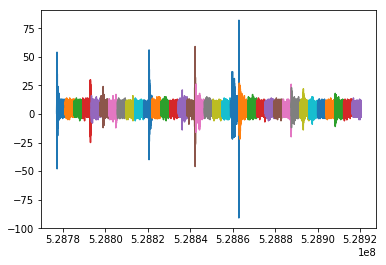

In [5]:
s = 1 #s step in signal-wise
for i in np.arange(len(index_steps)-1):
#for i in np.arange(0,10,s):
    plt.plot(signal_1['acoustic_data'][index_steps[i]:index_steps[i+s]])

Acá, vemos que sucede con el PSD de 'signal_2', tambien suavizamos un poco la curva con 'savgol_filter'. 
Para ver la forma de las graficas con intensidades pequeñas, esta normalizado con el maximo de la curva:

0.32967032967032966
mean: 0.07338508097831743


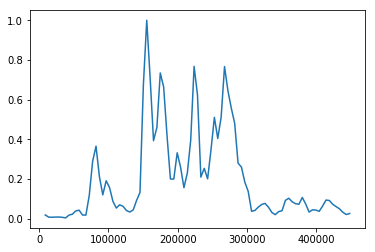

In [6]:

from scipy.signal import savgol_filter
#plt.yscale('log')
#for i in np.arange(len(index_steps)-1):
for i in np.arange(0,1,s):
    quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_3[index_steps[i]:index_steps[i+s]])
    index_max = np.argmax(power_spectrum) 
    #print(index_max)
    #print(_frequencies[index_max])
    print(feature_calculators.first_location_of_maximum(power_spectrum))
    print('mean:', np.mean(power_spectrum))

    
#savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0
    result = savgol_filter(power_spectrum, 15, 3)

    
    plt.plot(_frequencies, power_spectrum/np.max(power_spectrum))
    #plt.plot(_frequencies, power_spectrum)
    #plt.plot(_frequencies[:len(_frequencies)-1], np.diff(result/np.max(result)))

## Resumen y Conclusiones

La propuesta, es de caracterizar los parametros a entrenar, a partir de entender un poco de como se compone la señal que se pone a prueba. Como sabemos esta tiene 150 mil datos. La idea es tomar segmentos de la señal de 150 mil, partirlos en 36. Y evaluar una serie de caracteristicas para cada uno de los 36 segmentos. 
Por ejemplo: 
Propongo tomar las posiciones y valores de los 3 picos mas grandes. Y ordenarlos de la frecuencia menor a la mayor.
Esto quiere decir de los 36 segmentos tendremos en total $36*6 = 216$ parametros para predecir.
Otra idea es ir avanzando de a 150 mil/36 pasos, en vez de avanzar los 150 mil de una sola vez. Pues en el training set, el tiempo restante para el terremoto, esta discretizado por aproximadamente cada $4096$ datos $~ \frac{150000}{36} = 4166,6 $.  



### recursos
En la siguiente pagina, hay una función bacana para detectar picos de una cruva.

https://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

Aún no lo probé pero creo que funcionará bien usando un valor adecuado para el 'minimum peak distance' (mpd).




In [30]:
import heapq

#Nmax- how many max do you want?
def get_max_values(freq, power, Nmax=5):
    
    #finding peaks using inbuilt functions, condition on height
    #peaks_positive, _=signal.find_peaks(power_spectrum, height=0.1)
    #return indexes for power_spectrum
    peaks_positive, _=signal.find_peaks(power,  height=0.1)
    # find Nmax intensities values and order them
    max_intensities= np.array(heapq.nlargest(Nmax, power[peaks_positive]))
    #find Nmax intensities values and return their indexes
    index_frequencies= heapq.nlargest(Nmax, range(len(power[peaks_positive])), power[peaks_positive].__getitem__)
    #find max frequencies values
    max_frequencies=freq[peaks_positive][index_frequencies]
    #return numpy array
    return max_intensities, max_frequencies

max_int, max_freq= get_max_values(_frequencies, power_spectrum)

In [31]:
max_int

array([0.36977381, 0.28386714, 0.28354383, 0.27162697, 0.18898781])

In [32]:
max_freq

array([155273.4375, 223632.8125, 267578.125 , 174804.6875, 252929.6875])

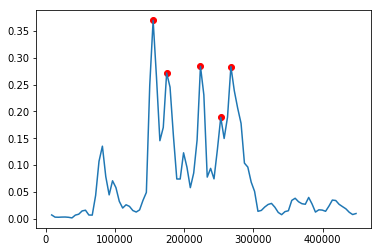

In [33]:
plt.plot( max_freq,max_int, 'ro')
plt.plot(_frequencies, power_spectrum)
plt.show()

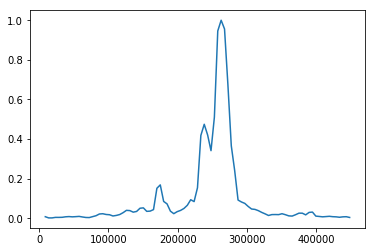

In [35]:
for i in np.arange(0,1,s):
    quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_2[index_steps[i]:index_steps[i+s]])
    index_max = np.argmax(power_spectrum) 
    result = savgol_filter(power_spectrum, 15, 3)  
    plt.plot(_frequencies, power_spectrum/np.max(power_spectrum))


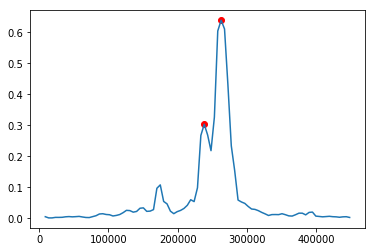

In [39]:
max_int, max_freq= get_max_values(_frequencies, power_spectrum, 2)
plt.plot( max_freq,max_int, 'ro')
plt.plot(_frequencies, power_spectrum)
plt.show()